## Imports

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data_train_path = 'skin-lesions/train/'
data_valid_path = 'skin-lesions/valid/'
data_test_path = 'skin-lesions/test/'

https://discuss.pytorch.org/t/is-there-a-limit-on-how-disbalanced-a-train-set-can-be/26334/6?u=ptrblck

## Loading Data

In [3]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# modified data from autoencoder
train_dataset = torch.load('model_data/upd_train_data.pt')

valid_dataset = ImageFolder(data_valid_path, transform = test_transform)
test_dataset = ImageFolder(data_test_path, transform = test_transform)

valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

### Applying SMOTE to data

In [10]:
modified_outputs, labels = [], []
for idx, (sample, target) in enumerate(tqdm(train_dataset, total=len(train_dataset))):
    modified_outputs.append(sample.cpu().detach().numpy())
    labels.append(target)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [11]:
X_train, y_train = np.array(modified_outputs), np.array(labels)

In [13]:
sm = SMOTE(random_state=42)

train_rows=len(X_train)
X_train = X_train.reshape(train_rows,-1)

X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1, 3, 224, 224)

In [14]:
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([1626, 1626]))


In [15]:
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

## Utility Functions

In [17]:
def train(model, epochs, criterion, min_loss, optimizer, vectorize=False):
    training_losses, valid_losses, accs = [],[],[]
    for epoch in range(epochs):
        training_loss = 0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            if vectorize:
                images = images.reshape(-1, 224 * 224 * 3)

            optimizer.zero_grad()
            ps = model(images)
            loss = criterion(ps, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()
        print(f"\tEPOCH: {epoch + 1}.. TRAINING LOSS: {training_loss}")

        training_losses.append(training_loss)
        model.eval()
        valid_loss = 0
        acc = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                
                if vectorize:
                    images = images.reshape(-1, 224 * 224 * 3)
                
                optimizer.zero_grad()
                ps = model(images)
                loss = criterion(ps, labels)
                
                valid_loss += loss.item()
                
                _, top_class = ps.topk(1, dim = 1)
                eq = top_class == labels.view(-1, 1)
                acc += eq.sum().item()
                
        valid_losses.append(valid_loss)
        accs.append(acc)
        acc = (acc/len(valid_dataset)) * 100
        print("EPOCHS: {}/{}.. \tTRAINING LOSS: {:.6f}.. \tVALIDATION LOSS: {:.6f}.. \tACCURACY: {:.2f}%..".format(epoch + 1, epochs, training_loss, valid_loss, acc))
        
        if valid_loss <= min_loss:
            print("Saving Model {:.4f} ---> {:.4f}".format(min_loss, valid_loss))
            save_obj = OrderedDict([
                ("min_loss", valid_loss),
                ("model", model.state_dict())
            ])
            torch.save(save_obj, "/melanoma_model.pt")
            min_loss = valid_loss
            
    return training_losses, valid_losses, accs

Below function was obtained from Kaggle with modifications for our task/models.

In [ ]:
def test_model():
    classes = test_dataset.classes
    total_correct = 0
    count = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            ps = model(images)
            
            ps = nn.Softmax(dim = 1)(ps)
            
            top_p, top_class = ps.topk(2, dim = 1)
            eq = top_class == labels.view(-1, 1)
            total_correct += eq.sum().item()
            
            if count % 50 == 0:
                plt.imshow(transforms.ToPILImage()(images[0]))
                plt.title(f"P: {classes[top_class.item()]}.. C: {top_p.item() * 100}%.. GT: {classes[labels.item()]}..")
                plt.show()
            
            
                
            count += 1
                
    print("Total Correct: {}/{}".format(total_correct, len(test_dataset)))
    print("Total Accuracy: {:.2f}%".format((total_correct/len(test_dataset)) * 100))

## Training Loop

In [ ]:
torch.cuda.empty_cache()

model = models.resnet18()
model.fc = nn.Linear(512 * torchvision.models.resnet.BasicBlock.expansion,2)
model = model.to(device)

LEARNING_RATE = 1e-5
EPOCHS = 50
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

min_loss = -1
train_loss, valid_loss, accs = train(model, EPOCHS, criterion, min_loss, optimizer)

	EPOCH: 1.. TRAINING LOSS: 35.34774523973465
EPOCHS: 1/50.. 	TRAINING LOSS: 35.347745.. 	VALIDATION LOSS: 3.532059.. 	ACCURACY: 20.00%..
	EPOCH: 2.. TRAINING LOSS: 35.1899334192276
EPOCHS: 2/50.. 	TRAINING LOSS: 35.189933.. 	VALIDATION LOSS: 3.438892.. 	ACCURACY: 53.33%..
	EPOCH: 3.. TRAINING LOSS: 34.947949290275574
EPOCHS: 3/50.. 	TRAINING LOSS: 34.947949.. 	VALIDATION LOSS: 3.396151.. 	ACCURACY: 55.33%..
	EPOCH: 4.. TRAINING LOSS: 34.780230700969696
EPOCHS: 4/50.. 	TRAINING LOSS: 34.780231.. 	VALIDATION LOSS: 3.373739.. 	ACCURACY: 51.33%..
	EPOCH: 5.. TRAINING LOSS: 34.61360561847687
EPOCHS: 5/50.. 	TRAINING LOSS: 34.613606.. 	VALIDATION LOSS: 3.358706.. 	ACCURACY: 46.67%..
	EPOCH: 6.. TRAINING LOSS: 34.50395888090134


## Immediate Results

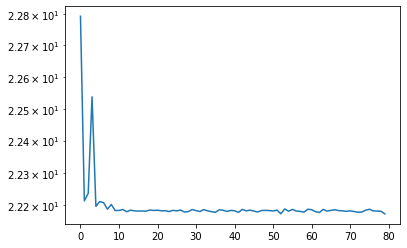

In [158]:
plt.semilogy(train_loss)

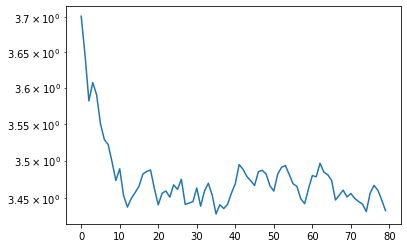

In [159]:
plt.semilogy(valid_loss)